In [32]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
import movingpandas as mpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
# import torch

import scipy
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import scipy.stats

In [33]:
# Set the filename
# filename = '../data/SharkArray-2020-05-21-thru-05-28.csv'
# filename = '../data/2020-21-max-3-min-run.csv'
filename = '../data/2020-13-141-long-5-min-run.csv'

# Load shark positions data into a GeoDataFrame
shark_gdf = pd.read_csv(filename)
shark_gdf['t'] = pd.to_datetime(shark_gdf['DATETIME'])
shark_gdf['geometry'] = gpd.points_from_xy(shark_gdf.LON, shark_gdf.LAT)
shark_gdf = gpd.GeoDataFrame(shark_gdf)
shark_gdf = shark_gdf.set_crs('EPSG:4326')
shark_gdf = shark_gdf.set_index('t').tz_localize(None)
shark_gdf.head()

,TRANSMITTER,DETECTEDID,DATETIME,X,Y,D,LAT,LON,n,HPE,HPEm,TEMP,DEPTH,ACCEL,DRX,URX,geometry
t,,,,,,,,,,,,,,,,,
2020-05-22 14:08:00,2020-13,A69-1602-8664,5/22/2020 14:08,4600.43,5936.79,5.0,34.407534,-119.553554,4,3.8,NaN,NaN,NaN,NaN,In_C Off_C Off_D OS2,In_C Off_C Off_D OS2,POINT (-119.55355 34.40753)
2020-05-22 14:09:00,2020-13,A69-1602-8664,5/22/2020 14:09,4599.47,5917.38,5.0,34.407359,-119.553564,6,3.4,NaN,NaN,NaN,NaN,In_B In_C Off_B Off_C OS2,In_B In_C Off_B Off_C OS2,POINT (-119.55356 34.40736)
2020-05-22 14:11:00,2020-13,A69-1602-8664,5/22/2020 14:11,4607.95,5920.45,5.0,34.407387,-119.553472,2,4.1,NaN,NaN,NaN,NaN,In_B In_C In_D In_E Off_A Off_B Off_C OS2,In_C Off_B Off_C OS2,POINT (-119.55347 34.40739)
2020-05-22 14:12:00,2020-13,A69-1602-8664,5/22/2020 14:12,4593.15,5926.50,5.0,34.407441,-119.553633,2,4.2,NaN,NaN,NaN,NaN,In_C In_D Off_D OS2,In_C In_D Off_D OS2,POINT (-119.55363 34.40744)
2020-05-22 14:16:00,2020-13,A69-1602-8664,5/22/2020 14:16,4600.73,5926.08,5.0,34.407437,-119.553551,9,3.3,NaN,NaN,NaN,NaN,In_B In_C In_D Off_B Off_C Off_D OS1 OS2,In_C In_D Off_B Off_C Off_D OS2,POINT (-119.55355 34.40744)


In [34]:
print('The dataset contains', shark_gdf.shape[0], 'rows and', shark_gdf.shape[1], 'columns.')
print('The column names are:', list(shark_gdf.columns.values))
print('The unique transmitter names are:', shark_gdf['TRANSMITTER'].unique())

The dataset contains 141 rows and 17 columns.
The column names are: ['TRANSMITTER', 'DETECTEDID', 'DATETIME', 'X', 'Y', 'D', 'LAT', 'LON', 'n', 'HPE', 'HPEm', 'TEMP', 'DEPTH', 'ACCEL', 'DRX', 'URX', 'geometry']
The unique transmitter names are: ['2020-13']


In [35]:
# Create separate trajectories for each shark based on their transmitter ID
traj_collection = mpd.TrajectoryCollection(shark_gdf, 'TRANSMITTER')
traj = traj_collection.trajectories[0]
print(traj_collection, traj)

TrajectoryCollection with 1 trajectories Trajectory 2020-13 (2020-05-22 14:08:00 to 2020-05-22 19:22:00) | Size: 141 | Length: 3186.1m
Bounds: (-119.555301, 34.40504, -119.549414, 34.409764)
LINESTRING (-119.553554 34.407534, -119.553564 34.407359, -119.553472 34.407387, -119.553633 34.4074


In [36]:
# Add a timedelta column which is the time between the previous position and the current position
n = traj.df.shape[0]
timedeltas = [timedelta()] + [traj.df.index[i] - traj.df.index[i - 1] for i in range(1, n)]
traj.df['TIMEDELTA'] = timedeltas

In [37]:
# Add velocities and headings to each trajectory
traj.add_speed()
traj.add_direction()

In [38]:
# Compute turning angles
def bound_angle_diff(theta_diff):
    return ((theta_diff - 180) % 360) - 180

n = traj.df.shape[0]
turning_angles = [0] + [bound_angle_diff(traj.df['direction'][i + 1] - traj.df['direction'][i]) for i in range(1, n - 1)] + [0]
traj.df['turning_angle'] = turning_angles

Text(0.5, 1.0, 'Longest 3-min run trajectory')

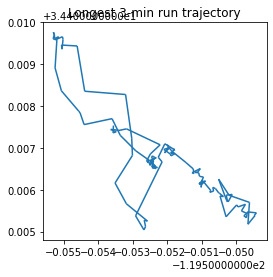

In [39]:
traj.plot(linestyle='None')
plt.title('Longest 3-min run trajectory')

In [40]:
# Create a random generator
rng = np.random.default_rng()

In [41]:
observations = []
num_missing = 0
for idx, row in traj.df.iterrows():
    # Append missing observations for minutes without an observation
    for i in range(max(int(row['TIMEDELTA'].total_seconds() / 60) - 1, 0)):
        num_missing += 1
        observations.append([0, 0.0, 0.0])
    observations.append([1, np.radians(row['turning_angle']), row['speed']])
# observations = np.array(observations)
p_missing = tf.constant(num_missing / len(observations), dtype=tf.float32)
print(p_missing, num_missing, len(observations))

tf.Tensor(0.552381, shape=(), dtype=float32) 174 315


In [42]:
# Define HMM parameters
# We assume 2 states
num_states = 2

# Randomly initialize the initial state distribution as well as the transition probabilities
initial_probs = tf.Variable(scipy.special.softmax(rng.random([num_states])), name='initial_probs', dtype=tf.float32)
transition_probs = tf.Variable(scipy.special.softmax(rng.random([num_states, num_states]), axis=1), name='transition_probs', dtype=tf.float32)

# Create distributions
initial_dist = tfd.Categorical(probs=initial_probs)
transition_dist = tfd.Categorical(probs=transition_probs)

# Initialize locations and concentrations of Von Mises distributions for turning angles
vm_locs = tf.Variable(np.zeros(num_states), dtype=tf.float32, name='vm_locs')
vm_cons = tf.Variable(np.zeros(num_states), dtype=tf.float32, name='vm_cons')

# Initialize shapes and rates of Gamma distributions for step length
gamma_shapes = tf.Variable(np.ones(num_states), dtype=tf.float32, name='gamma_shapes')
gamma_rates = tf.Variable(np.ones(num_states), dtype=tf.float32, name='gamma_rates')

obs_dist = tfd.Blockwise([
    tfd.VonMises(loc=vm_locs, concentration=vm_cons),
    tfd.Gamma(concentration=gamma_shapes, rate=gamma_rates)
])

print("Initial state probs:\n{}".format(initial_probs))
print("Transition matrix:\n{}".format(transition_probs))
print('von Mises locations:\n{}'.format(vm_locs))
print('von Mises concentrations:\n{}'.format(vm_cons))
print('Gamma shapes:\n{}'.format(gamma_shapes))
print('Gamma rates:\n{}'.format(gamma_rates))
print(initial_dist)
print(transition_dist)
print(obs_dist)

Initial state probs:
<tf.Variable 'initial_probs:0' shape=(2,) dtype=float32, numpy=array([0.3238358, 0.6761642], dtype=float32)>
Transition matrix:
<tf.Variable 'transition_probs:0' shape=(2, 2) dtype=float32, numpy=
array([[0.45220357, 0.5477964 ],
       [0.43518037, 0.56481963]], dtype=float32)>
von Mises locations:
<tf.Variable 'vm_locs:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>
von Mises concentrations:
<tf.Variable 'vm_cons:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>
Gamma shapes:
<tf.Variable 'gamma_shapes:0' shape=(2,) dtype=float32, numpy=array([1., 1.], dtype=float32)>
Gamma rates:
<tf.Variable 'gamma_rates:0' shape=(2,) dtype=float32, numpy=array([1., 1.], dtype=float32)>
tfp.distributions.Categorical("Categorical", batch_shape=[], event_shape=[], dtype=int32)
tfp.distributions.Categorical("Categorical", batch_shape=[2], event_shape=[], dtype=int32)
tfp.distributions.Blockwise("Blockwise", batch_shape=[2], event_shape=[2], dtyp

In [43]:
# Function to compute the log probability with the option to include previous forward variables to continue a sequence
def log_prob(observations, initial_dist, transition_dist, obs_dist, p_missing, previous_forward_vars=None):
    # Dictionary to hold the forward variables for each time step
    forward_vars = []
    
    log_p_missing = tf.math.log(p_missing)
    log_p_obs = tf.math.log(1 - p_missing)
    if previous_forward_vars is None:
        # Compute the initial forward variables
        forward_vars.append(log_p_obs + obs_dist.log_prob(observations[0][1:]) + initial_dist.log_prob(range(0, num_states)))
        start_idx = 1
    else:
        forward_vars.append(previous_forward_vars)
        start_idx = 0
    
    # Cache some values
#     transition_log_probs_T = tf.transpose(tf.math.log(transition_probs))
    transition_log_probs_T = transition_dist.log_prob(np.array([np.arange(num_states)] * num_states).T)
    
    # Loop through each observation, iteratively computing the forward variables
    for obs in observations[start_idx:]:
        # If the observation is missing:
        if obs[0] == 0:
            log_p_obs_given_state = log_p_missing
        else:
            log_p_obs_given_state = log_p_obs + obs_dist.log_prob(obs[1:])
        alpha_t = tf.reduce_logsumexp(transition_log_probs_T + forward_vars[-1], axis=1) + log_p_obs_given_state
        forward_vars.append(alpha_t)
        
    return tf.reduce_logsumexp(forward_vars[-1]), forward_vars[-1]

In [44]:
# Define a loss function
def loss_func():
    lp, last_forward_vars = log_prob(
        observations, 
        initial_dist,
        transition_dist,
        obs_dist,
        p_missing
    )
    return -lp

# Define an optimizer to perform back propagation
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

# Make sure probabilities sum to 1
def normalize_probs(probs):
    abs_probs = tf.math.abs(probs)
    if len(probs.shape) > 1:
        sums = tf.reshape(tf.reduce_sum(abs_probs, axis=1), [probs.shape[0], 1])
    else:
        sums = tf.reduce_sum(abs_probs)
    return abs_probs / sums

def wrap_to_pi(A):
    return ((A - np.pi) % (2 * np.pi) - np.pi)

# Run a step of the optimizer
# @tf.function(autograph=False)
def train_op():
    with tf.GradientTape() as tape:
        neg_log_prob = loss_func()
    vars = [initial_probs, transition_probs, vm_locs, vm_cons, gamma_shapes, gamma_rates]
    grads = tape.gradient(neg_log_prob, vars)
    optimizer.apply_gradients(zip(grads, vars))
    initial_probs.assign(normalize_probs(initial_probs))
    transition_probs.assign(normalize_probs(transition_probs))
    vm_locs.assign(wrap_to_pi(vm_locs))
    vm_cons.assign(tf.math.abs(vm_cons))
    gamma_shapes.assign(tf.math.abs(gamma_shapes))
    gamma_rates.assign(tf.math.abs(gamma_rates))
    return (neg_log_prob, *vars), grads

In [45]:
# Train on the observations
loss_history = []
for step in range(500):
    ts, grads = train_op()
    loss, ip, tp, vl, vc, gs, gr = [t.numpy() for t in ts]
    loss_history.append(loss)
    if step % 100 == 0:
        print("step {}: log prob {}\nInitial probs: {}\nTransition probs:\n{}\nVon Mises locs: {}\nVon Mises cons: {}\nGamma shapes: {}\nGamma rates: {}\n".format(step, -loss, ip, tp, vl, vc, gs, gr))

step 0: log prob -501.5917053222656
Initial probs: [0.32147506 0.6785249 ]
Transition probs:
[[0.3543479  0.6456521 ]
 [0.33746165 0.66253835]]
Von Mises locs: [0. 0.]
Von Mises cons: [0.1        0.10000001]
Gamma shapes: [1.1 1.1]
Gamma rates: [1.1 1.1]

step 100: log prob -376.38134765625
Initial probs: [0.9035764  0.09642366]
Transition probs:
[[0.015175   0.984825  ]
 [0.03682937 0.9631707 ]]
Von Mises locs: [-0.10456896  2.011123  ]
Von Mises cons: [0.33656204 0.23163125]
Gamma shapes: [0.85723925 0.9870887 ]
Gamma rates: [2.6169348 4.992684 ]

step 200: log prob -358.6827697753906
Initial probs: [0.9255749  0.07442502]
Transition probs:
[[0.83117235 0.16882758]
 [0.08377167 0.9162283 ]]
Von Mises locs: [0.21290565 2.7474177 ]
Von Mises cons: [1.2309548  0.51302713]
Gamma shapes: [1.6209564 1.0381806]
Gamma rates: [3.9565299 7.5040255]

step 300: log prob -349.1629943847656
Initial probs: [0.93451875 0.06548122]
Transition probs:
[[0.8568093  0.1431907 ]
 [0.06548275 0.9345172 ]]


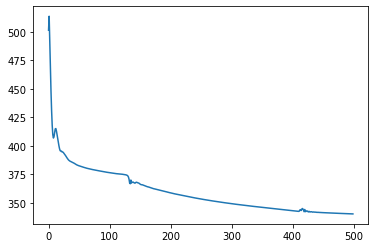

In [49]:
plt.plot(loss_history)

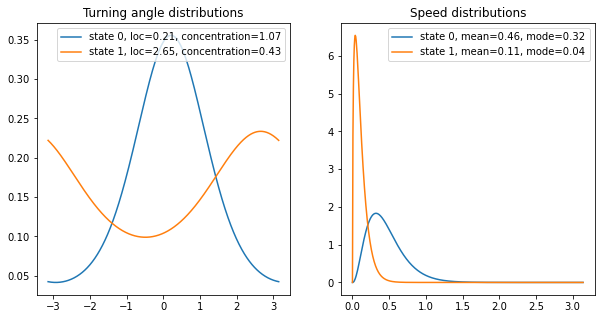

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot observation distributions
num = 1001
x = np.linspace(-np.pi, np.pi, num).reshape(num, 1)
for (j, (obs_dist, ax)) in enumerate(zip(obs_dist.distributions, axs)):
    y = obs_dist.prob(x).numpy()
    for i in range(y.shape[1]):
        if j == 0:
            label = 'state {}, loc={:.2f}, concentration={:.2f}'.format(i, vm_locs[i], vm_cons[i])
            title = 'Turning angle distributions'
        else:
            label = 'state {}, mean={:.2f}, mode={:.2f}'.format(i, gamma_shapes[i] / gamma_rates[i], (gamma_shapes[i] - 1) / gamma_rates[i])
            title = 'Speed distributions'
        ax.plot(x[:, 0], y[:, i], label=label)
        ax.set_title(title)
        ax.legend(loc='upper right')
plt.show()

In [48]:
obs_dist

<tfp.distributions.Gamma 'Gamma' batch_shape=[2] event_shape=[] dtype=float32>